In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.style.use('seaborn-whitegrid')

from shap.explainers import _tree # imports local fork
import shap # for plotting

/var/folders/yx/_8fch6cj6w5cfvy2xlfjrsyw0000gn/T/ipykernel_31651/2275898383.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


init from local version!
imported from folder


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Pictures for SHAP.

In [2]:
# load shap data
features = ['afdc', 'sex', 'married', 'pbhous', 'hsorged', 'black', 'hispanic', 'wkless13','age', 'prevearn']
features_str = ["Welfare", "Sex", "Married", "Public housing", "High school", "Black", "Hispanic", "Unemployed", "Age", "Previous earnings"]
rename_dict = dict(zip(features, features_str))

cf_SHAP_df = pd.read_csv("cf_SHAP_values.csv", index_col=0)
cf_iv_SHAP_df = pd.read_csv("cf_iv_SHAP_values.csv", index_col = 0)
df = pd.read_csv("final_df.csv", index_col=0)
df_features = df[features]
df_features_fancy = df_features.rename(columns=rename_dict)

In [3]:
# read SHAP interactions data
cf_SHAP_int = np.load("cf_SHAP_interactions.npy")
cf_iv_SHAP_int = np.load("cf_iv_SHAP_interactions.npy")

In [4]:
# load cf_SHAP pickle
import pickle
with open("cf_SHAP.pkl", "rb") as f:
    cf_SHAP = pickle.load(f)

### Cross sectional CATE

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


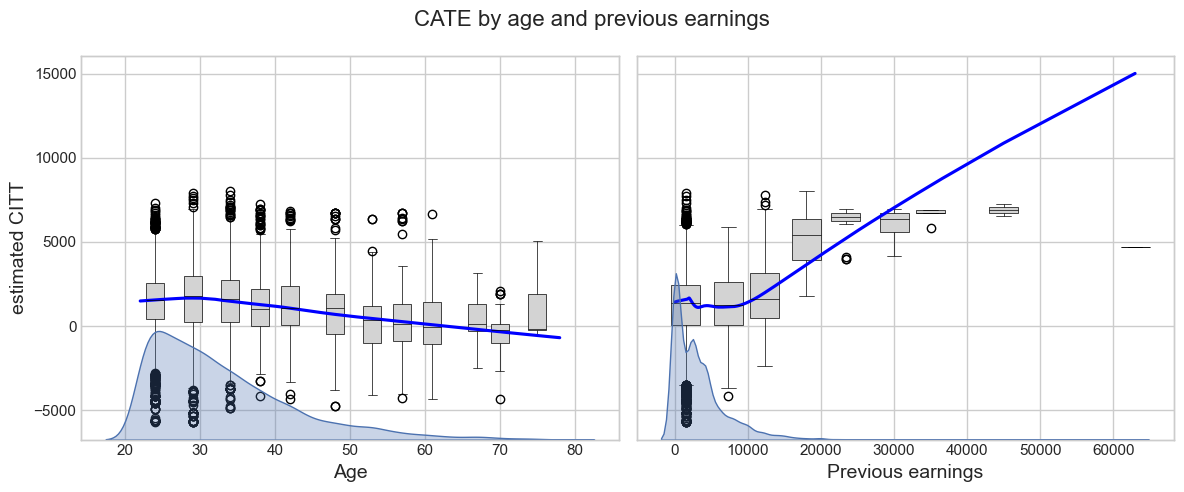

In [55]:
# same plot as before but create bins and plot boxplot for each bin

nr_bins = 12

# create bins and get median for each bin
df["age_bin"] = pd.cut(df.age, bins=nr_bins)
df["age_bin_median"] = df.groupby("age_bin")["age"].transform("median")
df["prevearn_bin"] = pd.cut(df.prevearn, bins=nr_bins)
df["prevearn_bin_median"] = df.groupby("prevearn_bin")["prevearn"].transform("median")

# plot
f, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.subplots_adjust(wspace=0.08)  # Adjust the horizontal spacing

ax2 = axs[0].twinx()
ax2.set_ylim(0, 0.2)
sns.kdeplot(df["age"], ax=ax2, fill=True, alpha=0.3)
ax2.yaxis.set_visible(False)
ax2.grid(False)
sns.boxplot(x="age_bin_median", y="CATE_cf", data=df, ax=axs[0], 
            color = "lightgrey", linecolor="black", native_scale=True, linewidth=0.5)
sns.regplot(x="age", y="CATE_cf", data=df, scatter=False, ax=axs[0], color = "blue", lowess=True)

ax3 = axs[1].twinx()
ax3.set_ylim(0, 0.0005)
sns.kdeplot(df["prevearn"], ax=ax3, fill=True, alpha=0.3)
ax3.yaxis.set_visible(False)
ax3.grid(False)
sns.boxplot(x="prevearn_bin_median", y="CATE_cf", data=df, ax=axs[1], 
            color = "lightgrey", linecolor="black", native_scale=True, linewidth=0.5)
sns.regplot(x="prevearn", y="CATE_cf", data=df, scatter=False, lowess=True, color="blue", ax=axs[1])

# set y title
axs[0].set_ylabel("estimated CITT", fontsize=14)
axs[1].set_ylabel("estimated CITT", fontsize=14)

# set x title
axs[0].set_xlabel("Age", fontsize=14)
axs[1].set_xlabel("Previous earnings", fontsize=14)

# set suptitle
f.suptitle("CATE by age and previous earnings", fontsize = 16)

#sns.despine()
plt.tight_layout()

# save fig
plt.savefig("CATE_by_age_prev_earn.pdf", format='pdf', dpi=400)

plt.show()

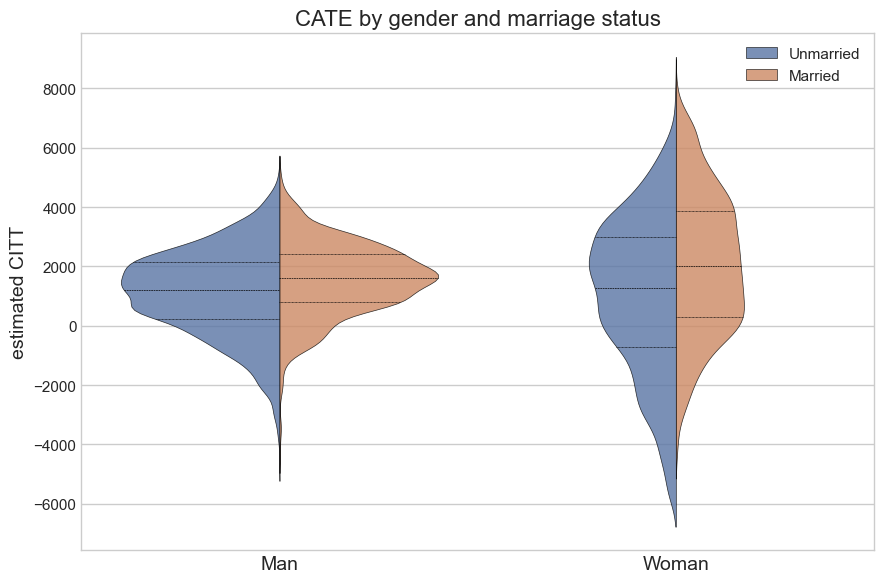

In [61]:
# plot across sex, married and education

# create binary str
df["married_str"] = df.married.map({0:"Unmarried", 1:"Married"})
df["gender_str"] = df.sex.map({0:"Man", 1:"Woman"})

plt.figure(figsize=(9, 6))

sns.violinplot(y = "CATE_cf", x = "gender_str", hue="married_str", data=df, linewidth=0.5, linecolor="black", alpha = 0.8, split=True, inner="quart")

# set x ticks to fontsize 14
plt.xticks(fontsize=14)

plt.ylabel("estimated CITT", fontsize=14)
plt.xlabel("")
plt.title("CATE by gender and marriage status", fontsize=16)
plt.legend()

plt.tight_layout()
# save fig
plt.savefig("CATE_by_sex_and_married.pdf", format='pdf', dpi=400)

plt.show()

### Heatmap

Didn't look too interestig in first look notebook...

### Waterfall demo

I do this on data from the California House prices.

In [54]:
ca = pd.read_csv("California_Houses.csv")
ca.shape


(20640, 14)

In [55]:
ca = ca.sample(5000)
ca.head()

,Median_House_Value,Median_Income,Median_Age,Tot_Rooms,Tot_Bedrooms,Population,Households,Latitude,Longitude,Distance_to_coast,Distance_to_LA,Distance_to_SanDiego,Distance_to_SanJose,Distance_to_SanFrancisco
13626,62900.0,1.8281,44,567,134,565,150,34.11,-117.27,79579.918584,89902.341859,155364.272071,550142.274836,617771.335894
3765,291700.0,4.3750,35,1975,384,882,406,34.18,-118.41,20135.649620,20886.772219,199836.967516,470972.254527,538994.875434
3208,67500.0,1.8385,14,2928,600,1633,559,36.33,-119.63,152343.109655,282866.810018,461118.452700,230348.762799,295917.732510
17119,148900.0,4.0039,36,1210,236,981,239,37.48,-122.14,1875.586471,518408.975349,696769.616836,27094.103979,41552.591229
5721,422000.0,3.6875,47,1853,345,757,310,34.18,-118.23,31205.237820,14262.552846,190640.968873,481953.324243,549987.526535


In [57]:
# get rid of _ in col names
ca.columns = ca.columns.str.replace("_", " ")

# get X and y
X = ca.drop("Median House Value", axis=1)
y = ca["Median House Value"]

In [59]:
# train regression forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# grid 
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_leaf': [4, 8, 10]
}

# grid search
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=4, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# get best estimator
best_rf = grid_search.best_estimator_
best_rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 20,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [60]:
# get SHAP
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer(X)

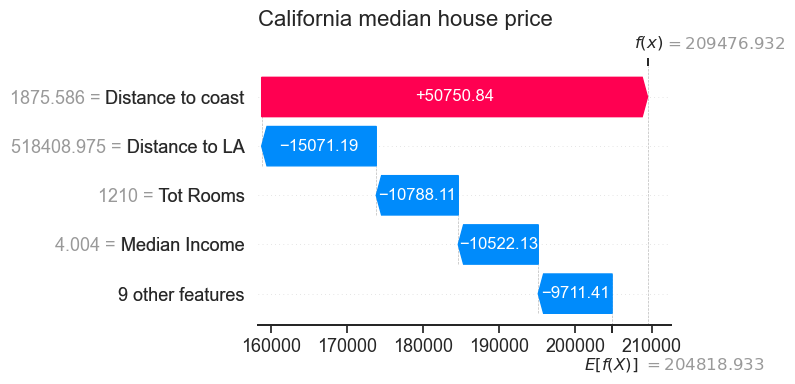

In [83]:
# get waterfall for random house
# 3 was good
ind = 3

shap.plots.waterfall(shap_values[ind], max_display=5, show = False)

plt.title("California median house price", fontsize = 16, loc = "left")
plt.tight_layout()

# save fig 
plt.savefig("shap_waterfall.pdf", format = "pdf", dpi = 400)
plt.show()

### SHAP interaction table

In [65]:
# get latex table of interaction value for 5th participant
cf_SHAP_int_df = pd.DataFrame(cf_SHAP_int[4], columns=features_str, index = features_str)
# to latex
cf_SHAP_int_ss = cf_SHAP_int_df.iloc[-3:,-3:].round(1)

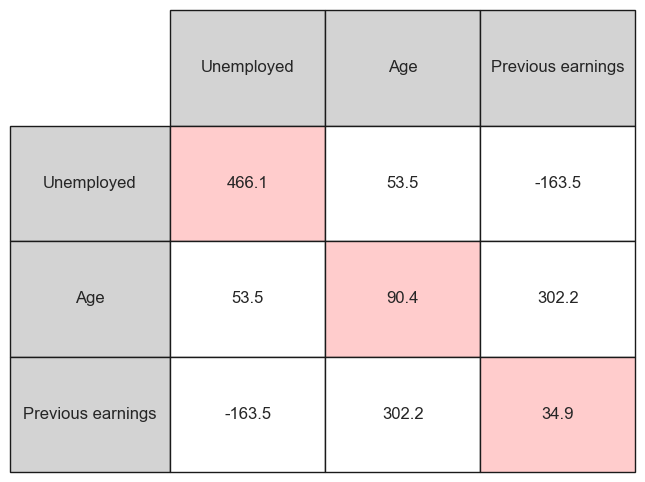

In [67]:
fig, ax = plt.subplots(figsize = (6, 6))
ax.axis("off")
table = ax.table(cellText=cf_SHAP_int_ss.values, colLabels=cf_SHAP_int_ss.columns, rowLabels=cf_SHAP_int_ss.index, loc='center', cellLoc='center', bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)  # Disable automatic font size
table.set_fontsize(12)  # Manually set the font size
table.scale(1.2, 1.2)  # Increase the cell size

# grey shade the diagonal of values
for i in range(3):
    table[(i+1,i)].set_facecolor("#FFCCCC")

# light blue shade the labels
for i in range(1, 4):  # start the range from 1, not 0
    table[(i,-1)].set_facecolor("#D3D3D3")  # this will shade the row labels
    table[0,i-1].set_facecolor("#D3D3D3")  # this will shade the column labels

# center row labels
for key, cell in table.get_celld().items():
    if key[1] == -1:  # this is a row label cell
        cell.get_text().set_horizontalalignment('center')  # center the text

# save fig
plt.savefig("SHAP_interaction_table.pdf", format = "pdf", bbox_inches = "tight", dpi = 400)

plt.show()

### CITT and CLATE distribution (smaller)

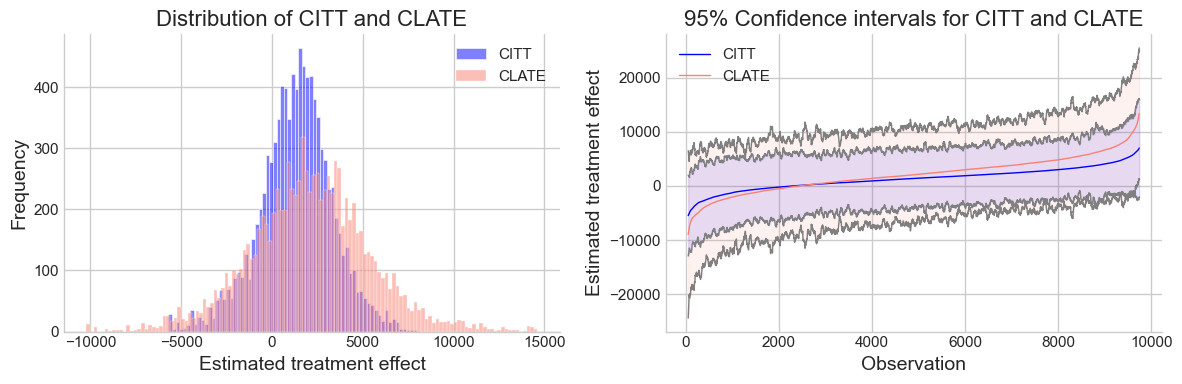

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=False)

# ax0
sns.histplot(df, x="CATE_cf", label = "CITT", alpha = 0.5, color="blue", ax=axs[0], binwidth=200)
sns.histplot(df, x="CATE_cf_iv", label = "CLATE", alpha = 0.5, color="salmon", binwidth = 200, ax=axs[0])

axs[0].set_title("Distribution of CITT and CLATE", fontsize = 16)
axs[0].set_ylabel("Frequency", fontsize = 14)
axs[0].set_xlabel("Estimated treatment effect", fontsize = 14)
axs[0].legend()

#ax1
# plot rolling mean of CATE and bounds
plot_df = df[['CATE_cf', 'CATE_cf_lb', 'CATE_cf_ub']].sort_values("CATE_cf").rolling(50).mean().reset_index().reset_index(drop=False, names = "Observation")
plot_df_iv = df[['CATE_cf_iv', 'CATE_cf_iv_lb', 'CATE_cf_iv_ub']].sort_values("CATE_cf_iv").rolling(50).mean().reset_index().reset_index(drop=False, names = "Observation")

linewidth = 1


# put them over one another
sns.lineplot(data=plot_df, ax=axs[1], y = "CATE_cf", x = "Observation", color="blue", label="CITT", linewidth = linewidth)
sns.lineplot(data=plot_df, ax=axs[1], y = "CATE_cf_ub", color="grey",x = "Observation", linewidth = linewidth)
sns.lineplot(data=plot_df, ax=axs[1], y = "CATE_cf_lb", color="grey",x = "Observation", linewidth = linewidth)
# fill between
axs[1].fill_between(plot_df.Observation, plot_df.CATE_cf_lb, plot_df.CATE_cf_ub, color='blue', alpha=0.1)

sns.lineplot(data=plot_df_iv, ax=axs[1], y = "CATE_cf_iv", color="salmon",x = "Observation", label="CLATE", linewidth = linewidth)
sns.lineplot(data=plot_df_iv, ax=axs[1], y = "CATE_cf_iv_ub", color="grey",x = "Observation", linewidth = linewidth)
sns.lineplot(data=plot_df_iv, ax=axs[1], y = "CATE_cf_iv_lb", color="grey",x = "Observation", linewidth = linewidth)
# fill between
axs[1].fill_between(plot_df_iv.Observation, plot_df_iv.CATE_cf_iv_lb, plot_df_iv.CATE_cf_iv_ub, color='salmon', alpha=0.1)

axs[1].set_title("95% Confidence intervals for CITT and CLATE", fontsize = 16)
axs[1].set_ylabel("Estimated treatment effect", fontsize = 14)
axs[1].set_xlabel("Observation", fontsize = 14)

sns.despine()
plt.tight_layout()

# save fig
plt.savefig("CITT_CLATE_new.pdf", format = "pdf", dpi = 400)

plt.show()

### Stacked CITT and CLATE distribution

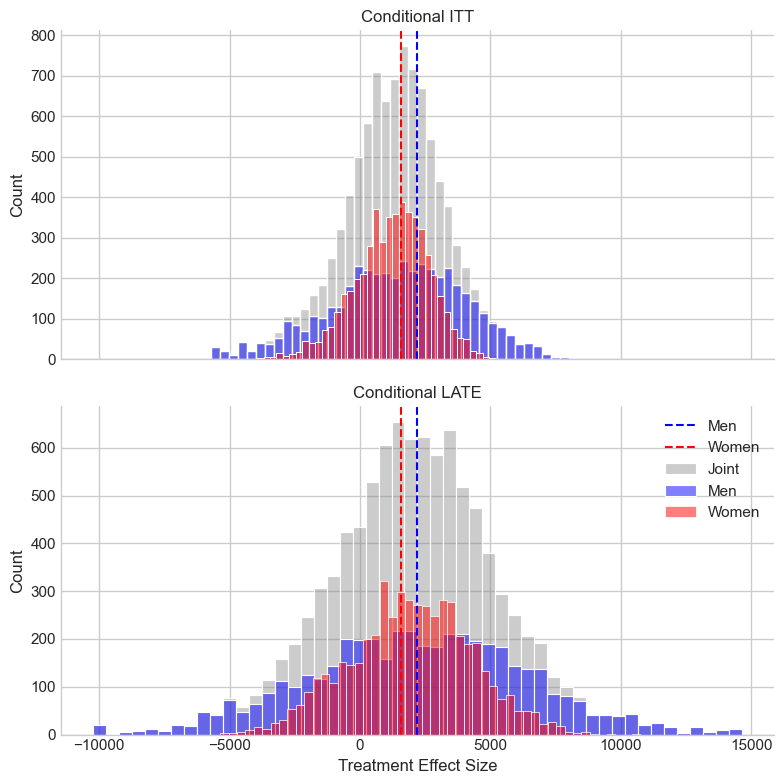

In [116]:
# plot CLATE and CITT distribution side by side in subplots

fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# CITT
sns.histplot(df, x="CATE_cf", label = "Joint", alpha = 0.4, color="grey", bins = 40, ax=axs[0])
sns.histplot(df.query("sex==1"), x="CATE_cf", color="blue", alpha = 0.5, label = "Men", bins = 40, ax=axs[0])
sns.histplot(df.query("sex==0"), x="CATE_cf", color="red", alpha = 0.5, label = "Women", bins = 40, ax=axs[0])
# add axvlines for LATE estimates
axs[0].axvline(x=2190, color="blue", linestyle="--", label="Men", ls = "--")
axs[0].axvline(x=1577, color="red", linestyle="--", label="Women", ls = "--")
axs[0].set_title("Conditional ITT")

# CLATE
sns.histplot(df, x="CATE_cf_iv", label = "Joint", alpha = 0.4, color="grey", bins = 50, ax=axs[1])
sns.histplot(df.query("sex==1"), x="CATE_cf_iv", color="blue", alpha = 0.5, label = "Men", bins = 50, ax=axs[1])
sns.histplot(df.query("sex==0"), x="CATE_cf_iv", color="red", alpha = 0.5, label = "Women", bins = 50, ax=axs[1])
# add axvlines for LATE estimates
axs[1].axvline(x=2190, color="blue", linestyle="--", label="Men", ls = "--")
axs[1].axvline(x=1577, color="red", linestyle="--", label="Women", ls = "--")
axs[1].set_title("Conditional LATE")

sns.despine()
plt.tight_layout()
plt.xlabel("Treatment Effect Size")
plt.legend()

plt.tight_layout()

plt.savefig("JointCF.pdf", format='pdf', dpi=400)

plt.show()

In [117]:
# compute spread above and below zero for CATE_cf and CATE_cf_iv
df[df["CATE_cf"] > 0].shape[0]/df.shape[0], df[df["CATE_cf"] < 0].shape[0]/df.shape[0], df[df["CATE_cf_iv"] > 0].shape[0]/df.shape[0], df[df["CATE_cf_iv"] < 0].shape[0]/df.shape[0]

(0.7680385918095043,
 0.23196140819049574,
 0.7542851277840501,
 0.24571487221594993)

### CATEs CI bounds

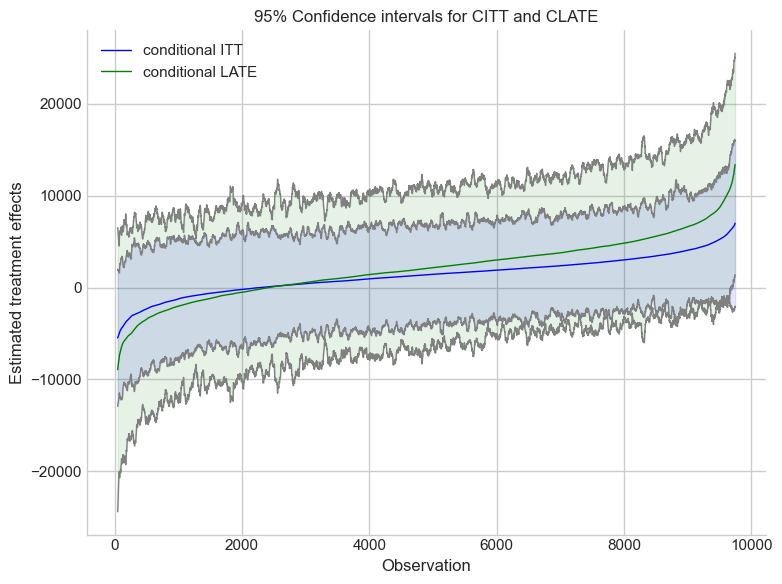

In [123]:
# plot rolling mean of CATE and bounds
plot_df = df[['CATE_cf', 'CATE_cf_lb', 'CATE_cf_ub']].sort_values("CATE_cf").rolling(50).mean().reset_index().reset_index(drop=False, names = "Observation")
plot_df_iv = df[['CATE_cf_iv', 'CATE_cf_iv_lb', 'CATE_cf_iv_ub']].sort_values("CATE_cf_iv").rolling(50).mean().reset_index().reset_index(drop=False, names = "Observation")

linewidth = 1

# create seaborn lineplot
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# put them over one another
sns.lineplot(data=plot_df, ax=ax, y = "CATE_cf", x = "Observation", color="blue", label="conditional ITT", linewidth = linewidth)
sns.lineplot(data=plot_df, ax=ax, y = "CATE_cf_ub", color="grey",x = "Observation", linewidth = linewidth)
sns.lineplot(data=plot_df, ax=ax, y = "CATE_cf_lb", color="grey",x = "Observation", linewidth = linewidth)
# fill between
ax.fill_between(plot_df.Observation, plot_df.CATE_cf_lb, plot_df.CATE_cf_ub, color='blue', alpha=0.1)

sns.lineplot(data=plot_df_iv, ax=ax, y = "CATE_cf_iv", color="green",x = "Observation", label="conditional LATE", linewidth = linewidth)
sns.lineplot(data=plot_df_iv, ax=ax, y = "CATE_cf_iv_ub", color="grey",x = "Observation", linewidth = linewidth)
sns.lineplot(data=plot_df_iv, ax=ax, y = "CATE_cf_iv_lb", color="grey",x = "Observation", linewidth = linewidth)
# fill between
ax.fill_between(plot_df_iv.Observation, plot_df_iv.CATE_cf_iv_lb, plot_df_iv.CATE_cf_iv_ub, color='green', alpha=0.1)


# set y axis labels

plt.ylabel("Estimated treatment effects")
plt.xlabel("Observation")
plt.title("95% Confidence intervals for CITT and CLATE")

sns.despine()
plt.tight_layout()

# save fig
plt.savefig("CITT_and_CLATE_ordered.pdf", format = "pdf", dpi = 400)

plt.show()



In [127]:
df.CATE_cf_pos_sign.sum(), df.CATE_cf_neg_sign.sum(), df.CATE_cf_iv_pos_sign.sum(), df.CATE_cf_iv_neg_sign.sum()

(388, 12, 427, 14)

### SHAP summary plot

would be stripplot, but 
- mass dependent jitter
- original feature value dependent coloring 

are kind of hard to recreate manually - maybe not worth it?

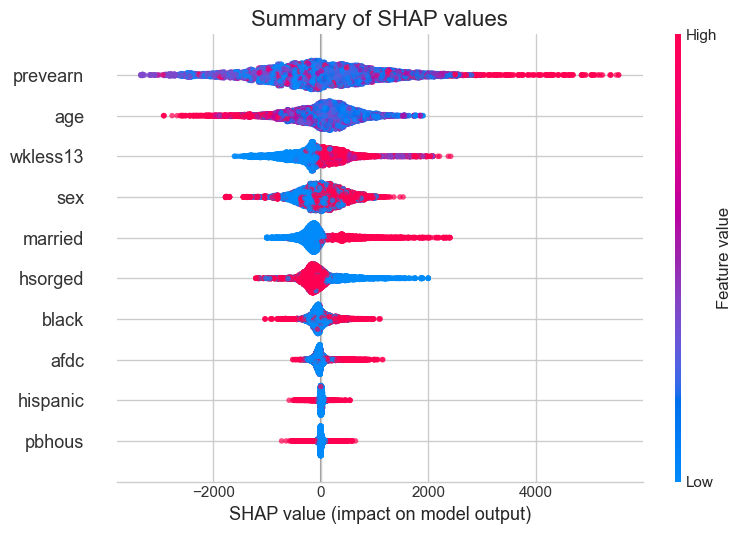

In [7]:
shap.plots.beeswarm(cf_SHAP, max_display=12, show=False, alpha = 0.7)
plt.title("Summary of SHAP values", fontsize = 16)

plt.tight_layout()
# save fig
plt.savefig("SHAP_beeswarm.pdf", format = "pdf", dpi = 400)
plt.show()

### Dependence plots

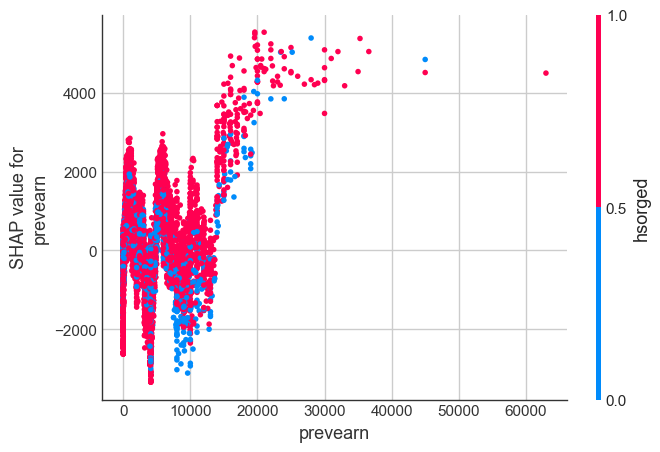

In [61]:
# dependence plot for the most important feature: previous earnings
shap.dependence_plot("prevearn", cf_SHAP_df.to_numpy(), df_features, interaction_index="hsorged")

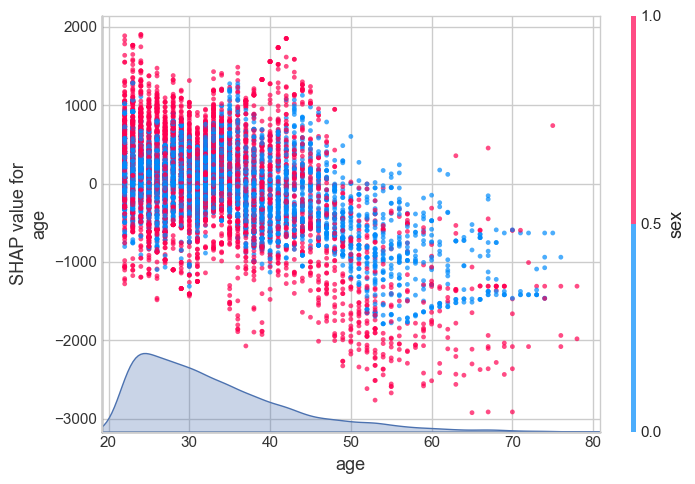

In [42]:
# use this?
shap.dependence_plot("age", cf_SHAP_df.to_numpy(), df_features, interaction_index="sex", alpha = 0.7, show=False, dot_size = 12)
# add age kde
ax = plt.gca()
# get twin x axis
ax2 = ax.twinx()
# plot density
sns.kdeplot(df_features["age"], ax=ax2, fill=True, alpha = 0.3)
ax2.yaxis.set_visible(False)
ax2.grid(False)
ax2.set_ylim(0, 0.3)

plt.tight_layout()

# save fig
plt.savefig("SHAP_dependence_age_sex.pdf", format = "pdf", dpi = 400)
plt.show()

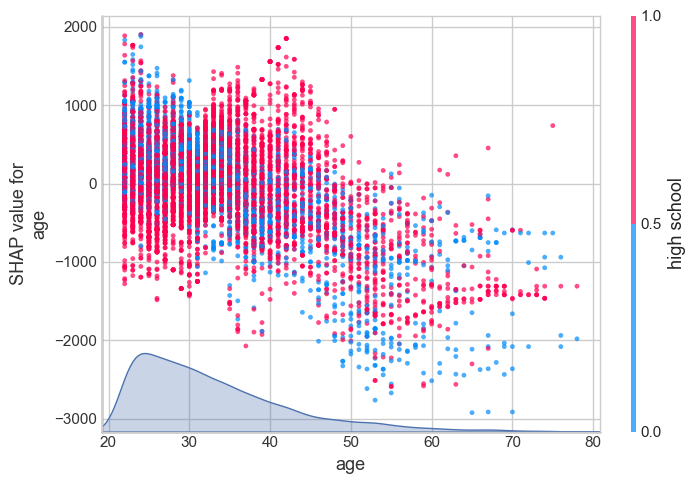

In [62]:
# use this?
shap.dependence_plot("age", cf_SHAP_df.to_numpy(), df_features_fancy, interaction_index="high school", alpha = 0.7, show=False, dot_size = 12)
# add age kde
ax = plt.gca()
# get twin x axis
ax2 = ax.twinx()
# plot density
sns.kdeplot(df_features["age"], ax=ax2, fill=True, alpha = 0.3)
ax2.yaxis.set_visible(False)
ax2.grid(False)
ax2.set_ylim(0, 0.3)

plt.tight_layout()

# save fig
plt.savefig("SHAP_dependence_age_education.pdf", format = "pdf", dpi = 400)
plt.show()

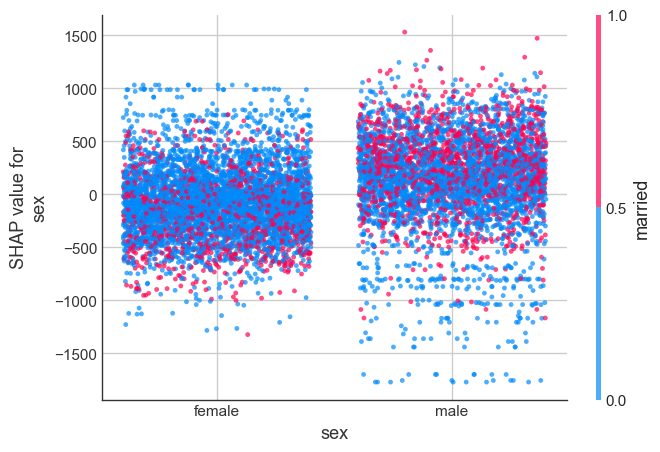

In [48]:
shap.dependence_plot("sex", cf_SHAP_df.to_numpy(), df_features, interaction_index="married", x_jitter=0.8, alpha = 0.7, show=False, dot_size = 12)
# rename x ticks to 0:female, 1: male
plt.xticks([0, 1], labels=["women","men"])
plt.show()

### SHAP interactions summary plot

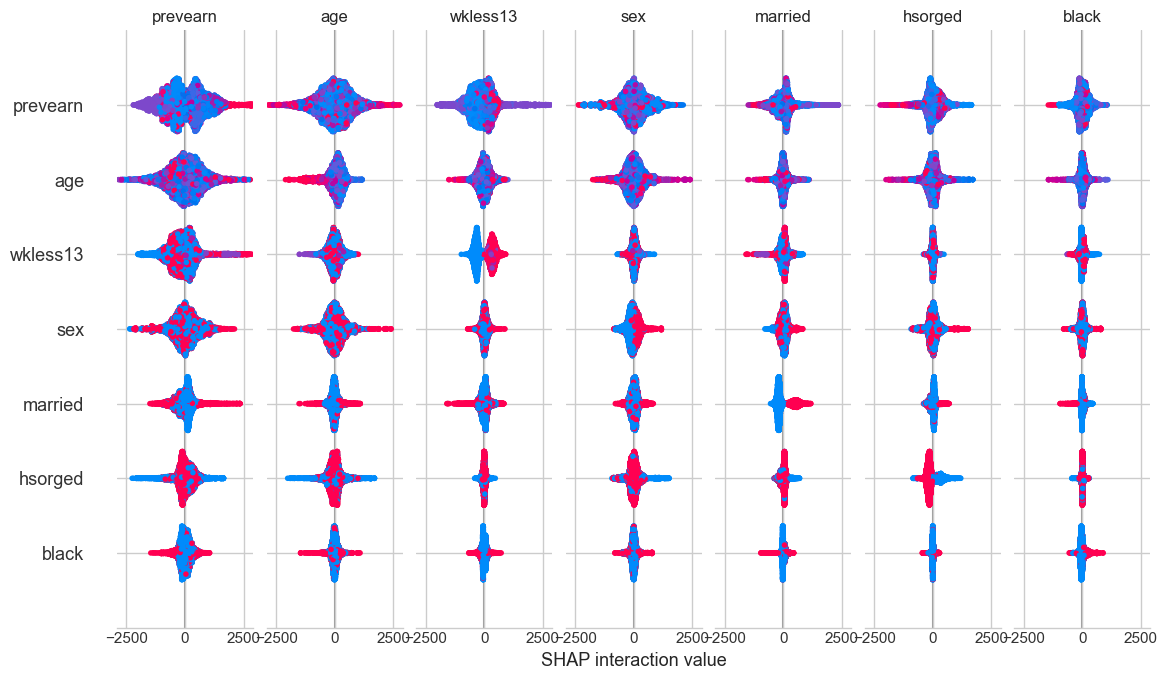

In [8]:
shap.summary_plot(cf_SHAP_int, df[features])

### Interaction SHAP values importance grid

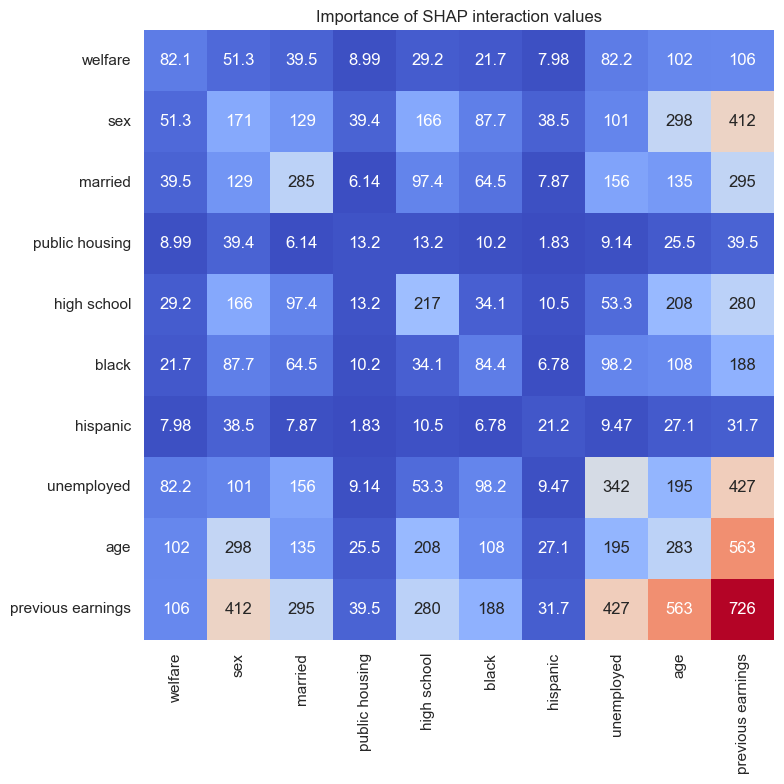

In [4]:
# Get absolute mean of matrices
mean_shap = np.abs(cf_SHAP_int).mean(0)
int_imp_df = pd.DataFrame(mean_shap,index=features_str,columns=features_str)

# times off diagonal by 2
int_imp_df.where(int_imp_df.values == np.diagonal(int_imp_df),int_imp_df.values*2,inplace=True)

# display 
plt.figure(figsize=(8,8), facecolor='w', edgecolor='k')
sns.set(font_scale=1)
sns.heatmap(int_imp_df,cmap='coolwarm',annot=True,fmt='.3g',cbar=False)
plt.yticks(rotation=0) 
plt.title("Importance of SHAP interaction values")
plt.tight_layout()
# save fig
#plt.savefig("SHAP_interaction_importance.pdf", format = "pdf", dpi = 400)


plt.show()

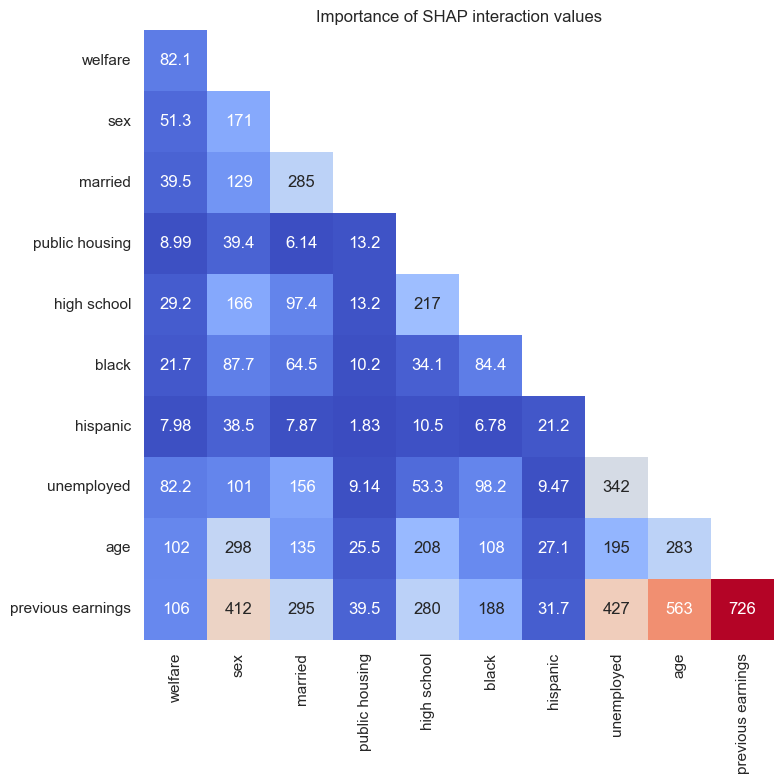

In [6]:
import numpy as np

sns.set(style="white")
# Create a mask for the upper triangle excluding the main diagonal
mask = np.triu(np.ones_like(int_imp_df, dtype=bool), k=1)

# Plot the heatmap with the mask
plt.figure(figsize=(8,8), facecolor='w', edgecolor='k')
sns.heatmap(int_imp_df, mask=mask, cmap='coolwarm', annot=True, fmt='.3g', cbar=False, vmax=int_imp_df.max().max())
plt.yticks(rotation=0) 
plt.title("Importance of SHAP interaction values")
plt.tight_layout()

# Save the figure
plt.savefig("SHAP_interaction_importance_masked.pdf", format = "pdf", dpi = 400)

plt.show()

### SHAP interaction dependence plots

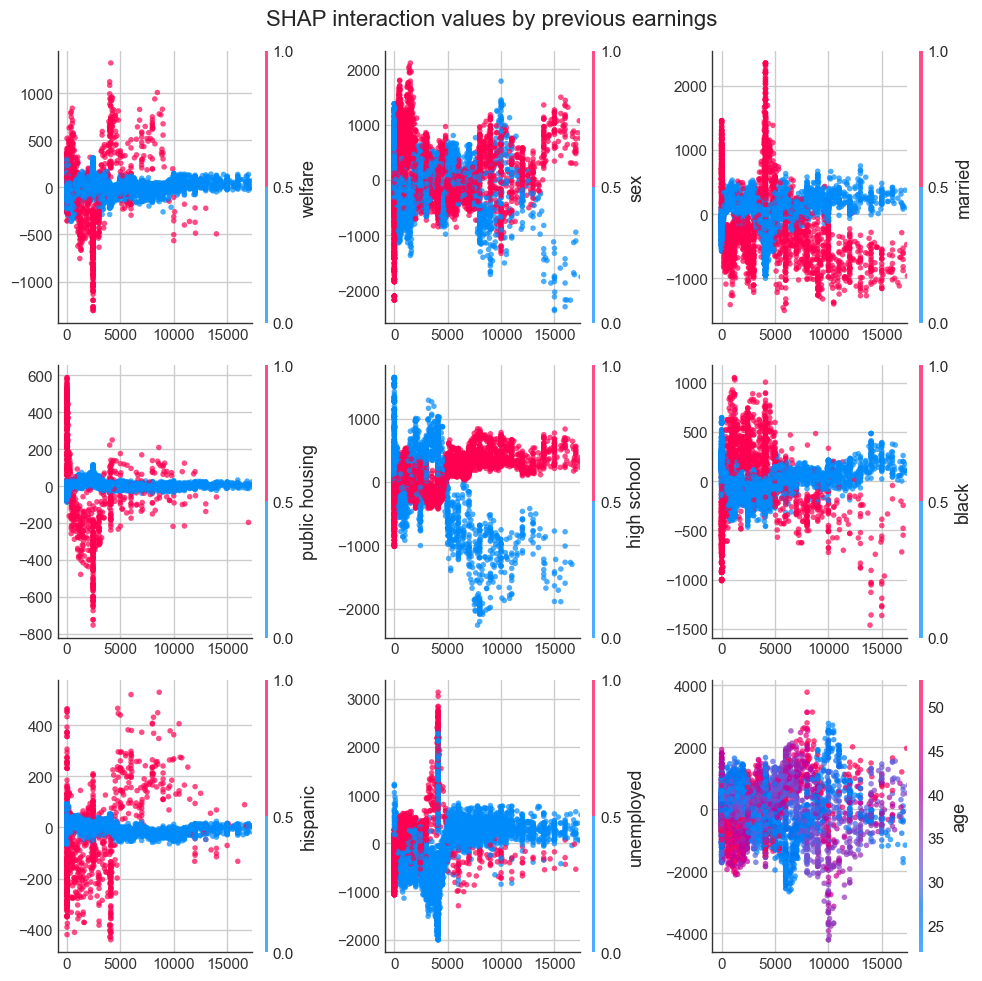

In [57]:
# get a 3x3 grid, and in each grid plot the SHAP interaction dependence plot with previous earnings
fig, axs = plt.subplots(3, 3, figsize=(10,10))

for i in range(9):
    shap.dependence_plot(("previous earnings", features_str[i]), cf_SHAP_int, 
                         df_features_fancy, show=False, alpha = 0.7, ax=axs[i//3, i%3],
                         xmax = "percentile(99)")
    # get rid of ytitle
    axs[i//3, i%3].set_ylabel("")
    # set xlim to 0, 20k
    #axs[i//3, i%3].set_xlim(0, 23000)
    # get rid of xtitle
    axs[i//3, i%3].set_xlabel("")

# set suptitle
plt.suptitle("SHAP interaction values by previous earnings", fontsize = 16)
plt.tight_layout()

# save fig
plt.savefig("SHAP_interaction_dependence_prevearn.pdf", format = "pdf", dpi = 400)

plt.show()

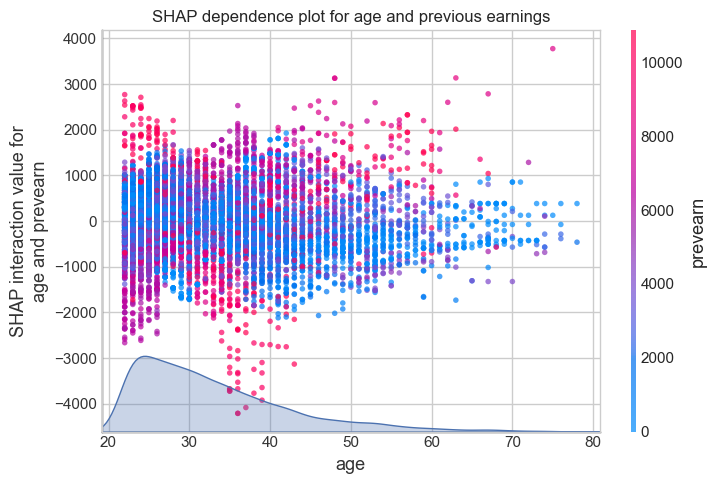

In [39]:
shap.dependence_plot(("age", "prevearn"), cf_SHAP_int, df_features, alpha = 0.7, show=False, dot_size=12)
plt.title("SHAP dependence plot for age and previous earnings")
# add density plot of age 
# get current axes
ax = plt.gca()
# get twin x axis
ax2 = ax.twinx()
# plot density
sns.kdeplot(df_features["age"], ax=ax2, fill=True, alpha = 0.3)
ax2.yaxis.set_visible(False)
ax2.grid(False)
ax2.set_ylim(0, 0.3)
plt.tight_layout()
plt.show()

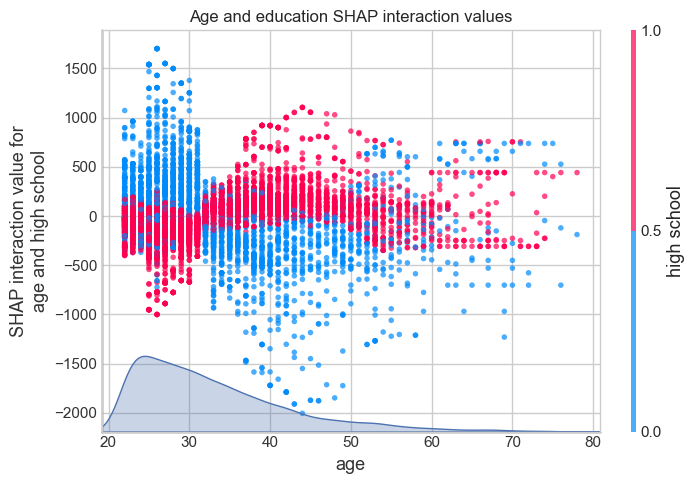

In [58]:
# same as before but look only at low earnings
shap.dependence_plot(("age", "high school"), cf_SHAP_int, df_features_fancy, alpha = 0.7, show=False, dot_size=12)
plt.title("Age and education SHAP interaction values")
# add density plot of age 
# get current axes
ax = plt.gca()
# get twin x axis
ax2 = ax.twinx()
# plot density
sns.kdeplot(df_features["age"], ax=ax2, fill=True, alpha = 0.3)
ax2.yaxis.set_visible(False)
ax2.grid(False)
ax2.set_ylim(0, 0.3)
plt.tight_layout()
# save fig
plt.savefig("SHAP_interaction_age_hsorged.pdf", format = "pdf", dpi = 400)
plt.show()

In [8]:
df_features_fancy.head()

,Welfare,Sex,Married,Public housing,High school,Black,Hispanic,Unemployed,Age,Previous earnings
recid,,,,,,,,,,
300001,0,0,0.0,0.0,1.0,1,0,1.0,46,0.0
300002,0,0,0.0,0.0,1.0,0,0,0.0,24,3591.0
300006,0,0,1.0,0.0,1.0,0,1,1.0,34,0.0
300008,0,0,0.0,0.0,1.0,0,0,0.0,31,9476.0
300012,0,1,0.0,1.0,1.0,1,0,1.0,22,200.0


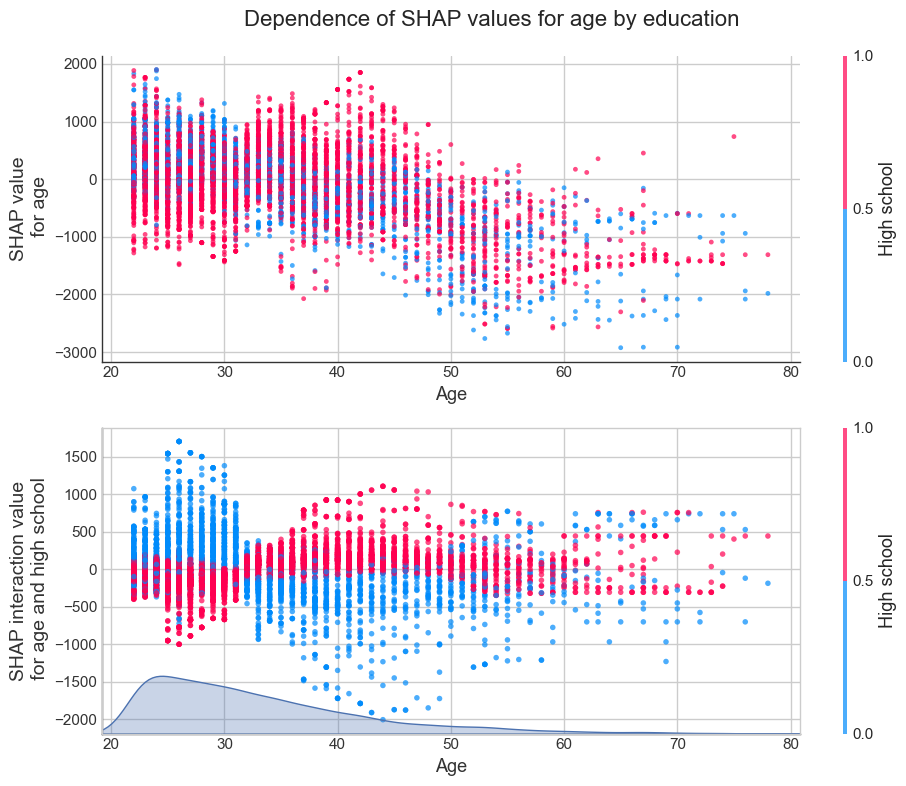

In [21]:
# combine dependence plots in two stacked x-sharing subplots
fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# add overall SHAP dependence
shap.dependence_plot("Age", cf_SHAP_df.to_numpy(), df_features_fancy, interaction_index="High school", alpha = 0.7, show=False, dot_size = 12, ax=axs[0])

# add interaction dependence
shap.dependence_plot(("Age", "High school"), cf_SHAP_int, df_features_fancy, alpha = 0.7, show=False, dot_size=12, ax=axs[1])
# add density plot of age 
ax2 = axs[1].twinx()
# plot density
sns.kdeplot(df_features["age"], ax=ax2, fill=True, alpha = 0.3)
ax2.yaxis.set_visible(False)
ax2.grid(False)
ax2.set_ylim(0, 0.3)

fig.suptitle("Dependence of SHAP values for age by education", fontsize = 16)
axs[0].set_ylabel("SHAP value\n for age", fontsize = 14)
axs[1].set_ylabel("SHAP interaction value\n for age and high school", fontsize = 14)

plt.tight_layout()

# save fig
plt.savefig("SHAP_dependence_age_education.pdf", format = "pdf", dpi = 400)
plt.show()

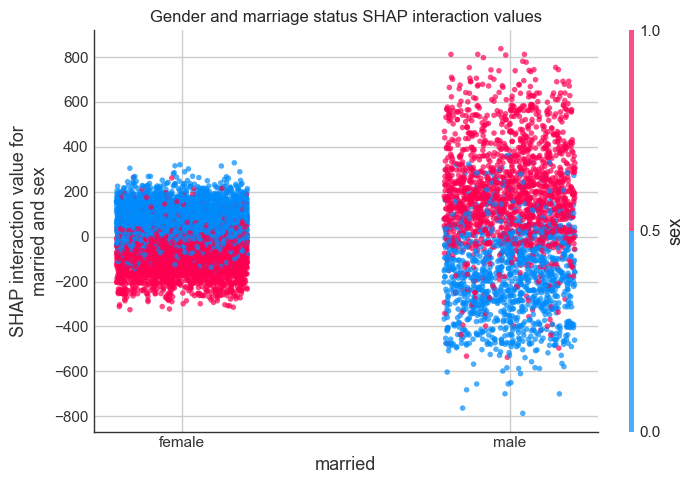

In [70]:
# plot for sex and married
shap.dependence_plot(("married", "sex"), cf_SHAP_int, df_features, alpha = 0.7, show=False, x_jitter = 0.4, dot_size=12)
plt.title("Gender and marriage status SHAP interaction values")

# rename x ticks to 0:female, 1: male
plt.xticks([0, 1], labels=["female","male"])
plt.tight_layout()

# save fig
#plt.savefig("SHAP_interaction_sex_married.pdf", format = "pdf", dpi = 400)

plt.show()

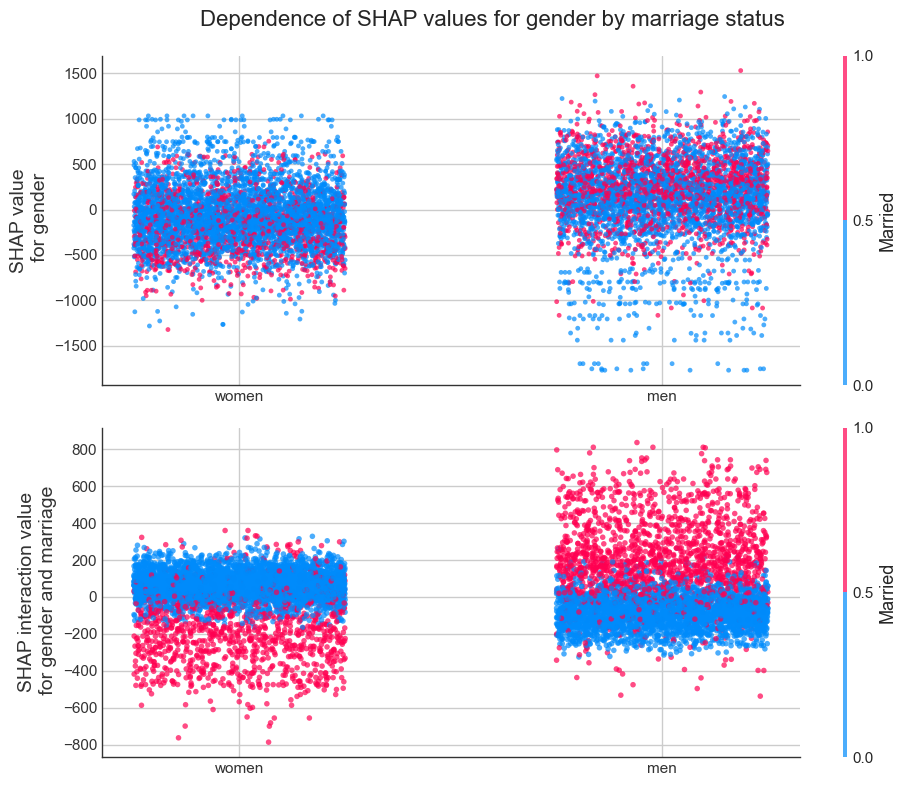

In [26]:
# create joint plot as above
fig, axs = plt.subplots(2, 1, figsize=(10,8), sharex=True)

# add main dependence
shap.dependence_plot("Sex", cf_SHAP_df.to_numpy(), df_features_fancy, interaction_index="Married", x_jitter=0.5, alpha = 0.7, show=False, dot_size = 12, ax=axs[0])
# rename x ticks to 0:female, 1: male
axs[0].set_xticks([0, 1], labels=["women","men"])

# add interaction dependence
shap.dependence_plot(("Sex", "Married"), cf_SHAP_int, df_features_fancy, alpha = 0.7, show=False, x_jitter = 0.5, dot_size=12, ax=axs[1])
# rename x ticks to 0:female, 1: male
axs[1].set_xticks([0, 1], labels=["women","men"])

fig.suptitle("Dependence of SHAP values for gender by marriage status", fontsize = 16)
axs[0].set_ylabel("SHAP value\n for gender", fontsize = 14)
axs[1].set_ylabel("SHAP interaction value\n for gender and marriage", fontsize = 14)
axs[0].set_xlabel("")
axs[1].set_xlabel("")

plt.tight_layout()

# save fig
plt.savefig("SHAP_dependence_sex_married.pdf", format = "pdf", dpi = 400)

plt.show()


### SHAP global importance plot

In [18]:
def abs_mean(array):
    return np.mean(np.abs(array))


glob_imp = cf_iv_SHAP_df.rename(columns=dict(zip(features, features_str))).apply(abs_mean, axis=0).sort_values(ascending=False)
glob_imp

Previous earnings    6.927119e+07
Age                  6.406885e+07
High school          4.992256e+07
Sex                  3.310951e+07
Public housing       8.733824e+06
Married              7.335348e+06
Welfare              5.692959e+06
Black                5.514005e+06
Unemployed           3.163766e+06
Hispanic             4.445007e+01
dtype: float64

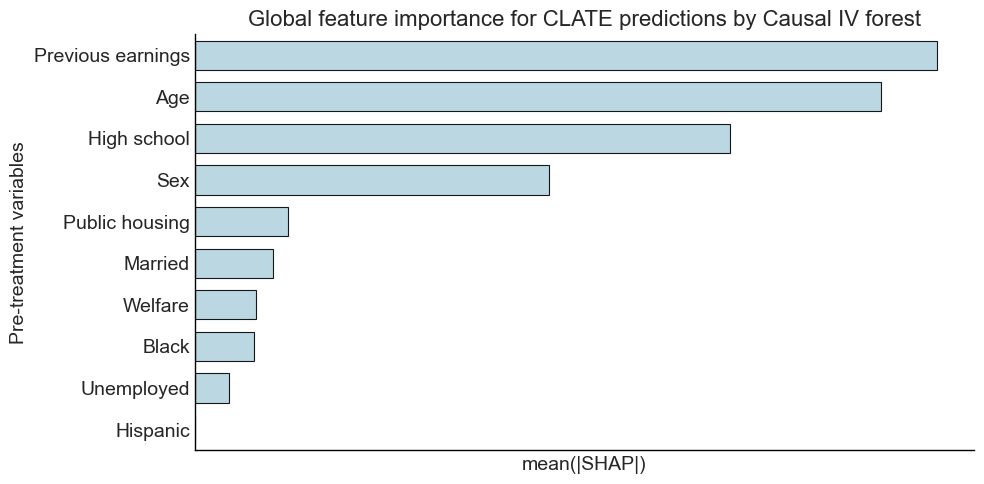

In [30]:
# create seaborn barplot
plt.figure(figsize=(10,5))
sns.barplot(x=glob_imp, y=glob_imp.index, color="lightblue", alpha = 0.9, orient="h", linewidth=0.8, edgecolor="black", width = 0.7)
plt.title("Global feature importance for CLATE predictions by Causal IV forest", fontsize = 16)
plt.xlabel("mean(|SHAP|)", fontsize = 14)
plt.ylabel("Pre-treatment variables", fontsize = 14)

# Increase the size of the y-axis labels
plt.tick_params(axis='y', labelsize=14)


# hide x-axis ticks
plt.xticks([])
# Change the color of the axes
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
sns.despine()
plt.tight_layout()

# save plot
plt.savefig("cf_iv_SHAP_feature_importance.pdf", format  = "pdf", dpi = 400)

plt.show()